# Test simulating baseline-LD genetic architecture

In [296]:
ldscore = admix_genet_cor.ldscore(dset)

/u/project/pasaniuc/kangchen/software/miniconda3/lib/python3.8/site-packages/dask/array/routines.py:313: PerformanceWarning: Increasing number of chunks by factor of 15
  intermediate = blockwise(


In [4]:
%load_ext autoreload
%autoreload 2
%load_ext lab_black

import pandas as pd

In [142]:
df_annot = pd.read_csv(
    "https://storage.googleapis.com/broad-alkesgroup-public/LDSCORE/baselineLD_v1.1_hg38_annots/baselineLD.22.annot.gz",
    sep="\t",
)

df_effect = pd.read_excel(
    "https://static-content.springer.com/esm/art%3A10.1038%2Fng.3954/MediaObjects/41588_2017_BFng3954_MOESM3_ESM.xlsx",
    sheet_name="S8c",
    skiprows=2,
).iloc[1:, [1, 4]]
df_effect.columns = ["name", "tau"]
df_effect = df_effect.set_index("name")

order = [
    "Coding",
    "Coding + 500bp",
    "Conserved (Lindblad-Toh)",
    "Conserved (Lindblad-Toh) + 500bp",
    "CTCF",
    "CTCF + 500bp",
    "DGF",
    "DGF + 500bp",
    "DHS Peaks",
    "DHS",
    "DHS + 500bp",
    "FANTOM5 Enhancer",
    "FANTOM5 Enhancer + 500bp",
    "Enhancer",
    "Enhancer + 500bp",
    "Fetal DHS",
    "Fetal DHS + 500bp",
    "H3K27ac (Hnisz)",
    "H3K27ac (Hnisz) + 500bp",
    "H3K27ac (PGC2)",
    "H3K27ac (PGC2) + 500bp",
    "H3K4me1 Peaks",
    "H3K4me1",
    "H3K4me1 + 500bp",
    "H3K4me3 Peaks",
    "H3K4me3",
    "H3K4me3 + 500bp",
    "H3K9ac Peaks",
    "H3K9ac",
    "H3K9ac + 500bp",
    "Intron",
    "Intron + 500bp",
    "Promoter Flanking",
    "Promoter Flanking + 500bp",
    "Promoter",
    "Promoter + 500bp",
    "Repressed",
    "Repressed + 500bp",
    "Super Enhancer (Hnisz)",
    "Super Enhancer (Hnisz) + 500bp",
    "TFBS",
    "TFBS + 500bp",
    "Transcribed",
    "Transcribed + 500bp",
    "TSS",
    "TSS + 500bp",
    "3 UTR",
    "3 UTR + 500bp",
    "5 UTR",
    "5 UTR + 500bp",
    "Weak Enhancer",
    "Weak Enhancer + 500bp",
    "Super Enhancer (Vahedi)",
    "Super Enhancer (Vahedi) + 500bp",
    "Typical Enhancer",
    "Typical Enhancer + 500bp",
    "Conserved (GERP NS)",
    "Conserved (GERP RS >= 4)",
    "MAF bin 1",
    "MAF bin 2",
    "MAF bin 3",
    "MAF bin 4",
    "MAF bin 5",
    "MAF bin 6",
    "MAF bin 7",
    "MAF bin 8",
    "MAF bin 9",
    "MAF bin 10",
    "MAF-Adjusted Allele Age",
    "LLD-AFR",
    "Recombination Rate (10kb)",
    "Nucleotide Diversity (10kb)",
    "Background Selection Statistic",
    "CpG-Content (50kb)",
]
dict_map = {o: a for a, o in zip(df_annot.columns[5:], order)}

df_effect.index = [dict_map[i] for i in df_effect.index]
df_effect = df_effect.loc[df_annot.columns[5:].values, :]

/u/project/pasaniuc/kangchen/software/miniconda3/lib/python3.8/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [148]:
import xrpgen

In [231]:
import dask.array as da

In [232]:
import sys

sys.path.append("/u/project/pasaniuc/kangchen/2021-admix-corr")
import admix_genet_cor

pgen_path = f"/u/project/pasaniuc/pasaniucdata/admixture/projects/PAGE-QC/s03_aframr/pgen/hm3/chr22.pgen"

dset = xrpgen.read_pfile(pgen_path, phase=True)
dset["lanc"] = (dset.geno.dims, da.from_zarr(pgen_path.replace(".pgen", ".lanc")))
dset.attrs["n_anc"] = 2

In [233]:
def impute_annot(dset, df_annot):
    """
    Impute annotation for a dataset, based on common SNP positions

    dset: data set to be imputed
    df_annot: reference dataframe of annotations
    """

    df_tmp = pd.DataFrame(
        {
            "BP": dset.coords["POS"].values,
            "SNP": dset.coords["snp"].values,
        }
    )
    df_tmp = pd.concat([df_tmp, df_annot]).sort_values("BP")
    df_tmp = (
        df_tmp.reset_index(drop=True)
        .interpolate(method="nearest")
        .set_index("SNP")
        .loc[dset.snp.values]
        .drop(columns=["BP", "CHR", "CM", "base"])
    )
    return df_tmp

In [216]:
df_imputed_annot = impute_annot(dset, df_annot)

In [226]:
import matplotlib.pyplot as plt

In [234]:
admix_genet_cor.af_per_anc(dset)

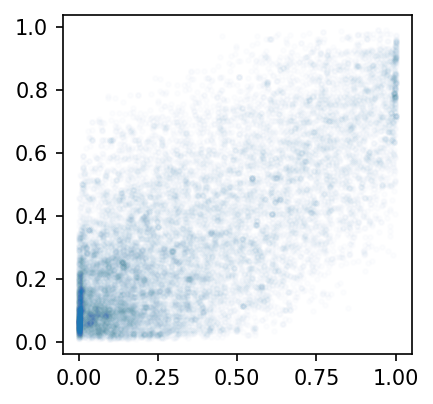

In [242]:
fig, ax = plt.subplots(figsize=(3, 3), dpi=150)
ax.scatter(dset.af_per_anc.values[:, 0], dset.af_per_anc.values[:, 1], alpha=0.01, s=5)
plt.show()

In [269]:
snp_var = df_imputed_annot.values.dot(df_effect["tau"].values) - 2.5
snp_var[snp_var < 0] = 0
np.mean(snp_var > 0)

0.030032200828021292

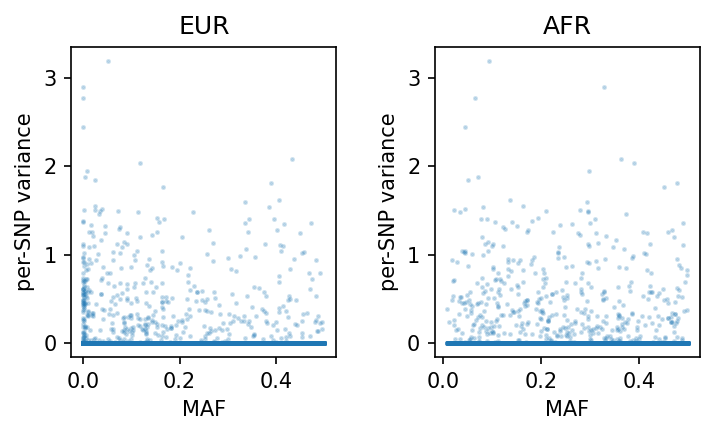

In [275]:
fig, axes = plt.subplots(figsize=(5, 3), dpi=150, ncols=2)
for anc_i in range(2):
    ax = axes[anc_i]
    maf = np.minimum(
        dset.af_per_anc.values[:, anc_i], 1 - dset.af_per_anc.values[:, anc_i]
    )
    ax.scatter(
        maf,
        snp_var,
        s=2,
        alpha=0.2,
    )
    ax.set_xlabel("MAF")
    ax.set_ylabel("per-SNP variance")
    ax.set_title("EUR" if anc_i == 0 else "AFR")
fig.tight_layout()